In [1]:
from gernerate_data import load_clas_seg_data
import tensorflow as tf
from sklearn.metrics import classification_report, auc, roc_curve
from keras.utils.np_utils import *
from keras.callbacks import LearningRateScheduler
from models.MTL_IBA import MTL_IBA, MTL_IBA_h3, MTL_IBA_cross3,MTL_IBA_s2c, MTL_IBA_cross3_pretrain
from models.MTL_Attention import MTL_Attention_model
# from models.shareLayer import create_pair_model
from sklearn.preprocessing import LabelBinarizer, label_binarize
from utils.losses import dice_coef_loss, dice_coef, dice_p_bce, dice_p_focal, tversky_loss, focal_loss, focal_tversky, \
    p_r_f1_iou, generalized_dice_coeff, generalized_dice_loss
from keras.losses import categorical_crossentropy, mean_squared_error, binary_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras.backend as K
import utils_paths
import numpy as np
import pickle
import os

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [ ]:
INIT_LR = 2e-4
EPOCHS =200
batch_size = 8
batch_size2 = 8
depth = 3
img_size = 224
Name = "MTL_IBA_cross3_pretrain"
GPU = True
target = (img_size, img_size)

if GPU:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"


    
print("------------------------------------------------ Preparing model ------------------------------------------------")
model = MTL_IBA_cross3(img_size, img_size, depth, nClasses=2)
# model = MTL_Attention_model(img_size, img_size, depth, nClasses=2)
model.summary()
# model.load_weights(" MTL_IBA_cross3_pretrain2.h5", by_name=True)

# model.load_weights("MTL_IBA_cross3_pretrain-043-0.9894.h5", by_name=True)

------------------------------------------------ Preparing model ------------------------------------------------
Instructions for updating:
Colocations handled automatically by placer.
lamb################################# Tensor("iba/Sigmoid:0", shape=(1, 28, 28, 256), dtype=float32)
Z_with_passing################################# Tensor("iba/mul_6:0", shape=(?, 28, 28, 256), dtype=float32)
output################################# Tensor("iba/cond_2/Merge:0", shape=(?, 28, 28, 256), dtype=float32)


2022-04-12 13:16:39.551645: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-12 13:16:39.581265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200095000 Hz
2022-04-12 13:16:39.585678: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x63d7950 executing computations on platform Host. Devices:
2022-04-12 13:16:39.585797: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2022-04-12 13:16:40.205641: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x6483980 executing computations on platform CUDA. Devices:
2022-04-12 13:16:40.205703: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-04-12 13:16:40.206777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: Tes

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 如果需要预训练分类分支，执行以下代码

In [3]:

import utils_paths
import random
import cv2

def scheduler(epoch):

    if epoch % 100 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)

def load_cla_data(train_imagePaths, target):

    data = []
    labels = []

    for imagePath in train_imagePaths:

        image = cv2.imread(imagePath)
        image = cv2.resize(image, target)
        data.append(image)
        print(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)

    data = np.array(data, dtype="float")
    #data = data.swapaxes(1, 3)
    data = data / 255.0
    labels = np.array(labels)

    return data, labels

print("------data loading-----")
train_path = 'dataset/Dataset_BUSI_AN4finetune/train/images/'# train_path = './dataset/OCT/train/'
test_path = train_path.replace('train', 'test')
val_path = train_path.replace('train', 'val')

train_imagePaths = sorted(list(utils_paths.list_images(train_path)))
val_imagePaths = sorted(list(utils_paths.list_images(val_path)))
test_imagePaths = sorted(list(utils_paths.list_images(test_path)))
random.seed(307)
random.shuffle(train_imagePaths)
random.shuffle(val_imagePaths)
random.shuffle(test_imagePaths)


train_x, train_y = load_cla_data(train_imagePaths, target)
val_x, val_y = load_cla_data(val_imagePaths, target)
test_x, test_y = load_cla_data(test_imagePaths, target)

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
val_y = lb.fit_transform(val_y)
test_y = lb.fit_transform(test_y)
# train_y = label_binarize(train_y, np.arange(2))
train_y = to_categorical(train_y, 2)
val_y = to_categorical(val_y, 2)
test_y = to_categorical(test_y, 2)

# # 数据增强处理
# aug = ImageDataGenerator(rotation_range=30,
#                          # brightness_range=(0.5, 0.9),
#                          # rescale=0.8,
#                          shear_range=0.2,
#                          zoom_range=0.1,
#                          horizontal_flip=True,
#                          # vertical_flip=True,
#                          fill_mode="nearest"
#                          )

print("------begin training -----")
opt = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)
#opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adam(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


# define callbacks
csv_logger = CSVLogger(Name+'.log')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-8, mode='auto', verbose=1)

checkpoint_period1 = ModelCheckpoint(Name + '-{epoch:03d}-{val_acc:.4f}.h5',
                                     monitor='val_acc', mode='auto', save_best_only='True', period=20)

checkpoint_period2 = ModelCheckpoint(Name + '-{epoch:03d}-{val_acc:.4f}.h5',
                                     monitor='val_acc', mode='auto', period=20)

# earlyStopping = EarlyStopping(monitor='val_acc', patience=20, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, min_lr=1e-8, mode='auto', verbose=1)
#
#
hist = model.fit(train_x, train_y,
                 batch_size=16,
                 epochs=EPOCHS,
                 validation_data=(val_x, val_y),
                 class_weight="auto",
                 verbose=1,
                 callbacks=[reduce_lr, checkpoint_period1, csv_logger])

# hist = model.fit_generator(aug.flow(train_x, train_y, batch_size=BS),
#                            validation_data=aug.flow(val_x, val_y),
#                            steps_per_epoch=len(train_x) // BS,
#                            class_weight={0: 0.8, 1: 1.2},
#                            validation_steps=5,
#                            workers=6,
#                            epochs=EPOCHS, callbacks=[checkpoint_period1, checkpoint_period2, csv_logger, reduce_lr])

print("------Saving model------")
# model.save('vgg16_150_ICIS_1-700X700.h5')
model_filename = Name + ".h5"
model.save_weights(model_filename)
print('model saved to:', model_filename)


print("------ testing ------")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
      predictions.argmax(axis=1), digits=6))


------data loading-----
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (114).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (124)_090997ef-a333-46e8-b267-cfdfd174942b.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (198)_34ecaca1-9c71-4235-85f1-ada37784304d.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (210).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (51)_1452949f-f862-43c3-95e5-fc802578fbd9.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (13)_5c4e99cd-2b97-46be-9aa9-309b1e71947f.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (112).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (141).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (29)_213149c1-dc78-4b8c-8ec9-59e11110d413.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (133

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (202)_db428d38-6f4e-47c8-9a12-edc55ef12cbd.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (151).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (195)_0290a185-60e7-4df6-b222-7e663dbd9fee.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (214).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (82).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (197)_907d89fb-3034-46ac-8aaf-c186c774a04a.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (127)_f0852266-f248-46ed-a4e2-143c70d90212.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (203)_b87d8c7b-c526-47fa-86d1-4fd278c153c4.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (6)_d18758a4-1542-4c75-a5de-4ffd80a06641.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_im

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (139).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (281).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (115)_5b819c12-b134-485e-b80c-12caef8968d2.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (329).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (187).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (7)_505c37fd-37c3-4e4c-9a24-39065dcb640a.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (360).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (26)_25711f08-acbe-49da-9dc0-e9e75e06d90a.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (4).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (83).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (91)_f0a95271-0f

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (144).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (188).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (47)_8ecd8b36-a3ac-4876-aaa4-cb5d4ea475b7.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (279)_8d4d9e72-62c3-46e9-b892-1cc0f2ed51d8.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (54)_141adc35-ff4f-4ca6-838d-84331f9975d5.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (100)_e9536ca0-e0ed-4e80-9c60-3df77d5d339a.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (159)_9d4995c4-0a87-46c6-8f13-c692c0d522a1.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (357)_decc2449-5b8f-477c-8d75-8ecb8037a62c.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (120)_4fb9dc2b-e85e-42e0-bf31-9a62e799490d.png
dataset/Dataset_BUSI_AN4fi

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (165)_724a51a4-3850-4d97-a15a-e502c0df84a9.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (159).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (87)_d734d42c-1656-47ca-97de-1766171ce383.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (400).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (45).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (269)_04d5ac0a-08fd-4bdd-b90b-900fcabd236f.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (36)_17f75cdd-136f-4e5f-a5ea-e0f64eb3ce32.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (202).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (73)_b01f8bb7-ab25-4879-8097-48a3be9a3483.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (399).png
dataset/Dataset_BUSI_AN4f

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (28)_34d011ac-e0c0-4821-9b80-9b4b8d54679d.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (3)_0503c343-0325-43ec-9b50-2c3935f21274.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (22).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (129)_9c3fef8c-e187-46be-b396-46e6de00288c.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (83)_9076cb6f-a432-4c04-859f-f9852955328e.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (142)_4731b337-5c08-4876-806e-3521130e79f1.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (61)_3c9ceb22-1451-47a3-bd65-77ce6684ba52.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (86)_f87aa04b-5920-4698-ba6b-fe097481f31b.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (430)_0f17bc53-6151-4b7e-8128-b6741

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (137).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (376)_6e0b291d-45e3-4ff8-aa59-65d83b825bdc.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (22).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (197).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (48).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (42).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (61)_a9e5232c-c7ee-4cfa-86a1-399e901b06e7.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (23)_4a11763c-6edb-410d-95e3-d9c85985abda.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (43)_d2a6d920-124a-419f-8382-7f88068ecf25.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (115)_61128333-c506-4dea-a2ae-8674f802d199.png
dataset/Dataset_BUSI_AN4fin

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (66)_2c274099-f77e-4e1f-8cb4-5fef107f2f8f.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (253)_f5acf1c7-0c14-49e0-9fdd-f4588e1b61c5.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (199)_ecd6ac1c-c015-485b-a7c0-5f7b9459d4d4.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (67)_080e2107-b37f-4e23-bdd0-bbecdcdb1e76.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (23)_008a3a0d-7448-48e2-bc56-92b3e402b5d8.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (147)_9d55be8b-561d-4c01-940f-689032133945.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (66)_cd389c14-46eb-40cc-b0af-4fc024817f16.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (103).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (176)_4303aa9b-b596-414c-8

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (273)_ac9a4b8b-09b2-444b-984a-5a1907d2f6f2.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (82)_41963bc4-8eb1-4e35-9339-0452fb7c3306.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (120)_bdcda2ed-d8f8-4f60-a2d7-e3c64f05b364.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (434)_3affc7e9-b020-433c-9e4e-40b3b4ceed70.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (110)_71b6bbbb-ede9-4ee0-8929-7de7e729851a.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (207)_7b904aa2-aaba-4fbe-aabd-7ef65f0b871e.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (2)_aff55bb9-82ec-4f2b-a6fd-559a28ecec00.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (186)_44137d31-e4ba-4ddc-a845-de0f88fbe9b9.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/mali

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (129).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (16)_1aa3c254-b407-4f51-9d97-16d5e64c0b6a.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (435).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (161)_61c37738-4406-4959-b65b-ba47b24ba6bb.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (43).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (164)_9bc99bb7-be83-4a60-97bf-8adf32f281e3.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (134)_bfc87a87-c362-4081-ba68-28c24de6bb5a.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (376)_f7274eb5-5b3f-444e-951b-85858b2ef14c.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (92)_1acfddb7-704b-4aa8-be21-95a7df6f2e2b.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (60)_4c6356eb-99db-4290-b68d-337fa5ed1e7f.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (325)_1cdd3ae4-00b4-4f14-ac70-e091c91edb64.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (105)_ef254d12-7786-4de8-9102-4c098bb8c781.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (25).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (100).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (101)_394144e4-c733-45ee-b20c-7c768c12b065.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (417).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (54).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (387)_46cc40a1-4953-46a8-b056-b54cba291ccf.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (407).png
dataset/Dataset_BUSI_AN4

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (79).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (47).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (86).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (28)_69b4eb6a-0d5d-4c2f-aaad-af05776a0581.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (132).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (417)_43e623c1-f9f3-4780-b5d1-47ed7ee46d1c.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (178)_b7d7713a-76bd-43f8-bc85-89a95061e3d4.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (151)_652a2e54-357a-49be-8aef-a3ab69cfec59.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (193)_84763fe4-ae9b-4729-96eb-7ac8dd89f6d7.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (318).png
dataset/Dataset_BUS

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (69).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (14).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (420)_439fbf4b-7758-4299-b6f1-01917f637875.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (135)_50e241ca-c4ee-401f-b09c-970f32cfc42b.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (103)_0a727626-58bc-4867-9298-5e09b288e52d.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (92)_f3b95a7e-65b4-47ca-813c-cd3b6d2ce993.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (345).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (76).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (49)_4c208a4e-5e37-4825-bd91-c9c2bd27ae8a.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (144).png
dataset/

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (358)_faae7cf8-e65f-4c76-86c7-5eaef113f71a.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (13).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (109).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (10).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (186).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (396)_673b5845-4a93-4be0-baf7-fae1ef90cffc.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (93)_4af85873-c395-4cc7-b0fb-a125e94b6562.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (66)_8b848608-5122-49c0-9ced-398caf91edad.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (279).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (228).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_

dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (52)_e759410d-b95e-47b0-aa16-40f724603d97.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (72)_15c89826-4c9e-4013-a37c-0fb283ee595d.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (192)_cde179b1-c0b7-4e0f-830d-1e98db78992d.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (374).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (159).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (81)_22bd354c-8016-41b0-8bc1-537e7d4e0151.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (30)_af7f7a7f-0749-4701-bc13-757ba6b3c205.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (195)_14ffd644-6700-46fd-8ecd-696554c2474b.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (20)_96fe858b-5ed6-401f-96cd-c660ec331bec.png
dataset/Dataset_BUSI_AN4finetune/tr

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (206)_b141877c-50bd-4c76-86bf-a5b14a63346b.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (137)_fc4f0eea-69df-4fcc-96be-450079879b07.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (118)_da6c3466-683b-46a0-b8d0-577139683ac6.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (157).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (78)_84386be5-2727-44d8-8868-d5b98425ccc9.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (192)_204ea7cb-3f2a-42b0-bea0-b52fd9ce0cb3.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (142)_8768c0f3-4b80-465f-8fe5-88379c493c33.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (70)_4ad25517-032d-45c4-8dc2-54906264c2dc.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (117).png
da

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (87)_6b4010b1-bc69-48d6-a827-ec9c1f858d0f.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (93)_dd6f34ce-80fa-495e-b10e-808cde836c11.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (26).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (97)_62286067-e654-4bd3-8951-8615e30f1bb6.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (344)_c142442c-8838-4c17-88a7-a0a36a271635.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (355)_da484afe-bda8-461d-8ade-2f375f3209e0.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (166).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (108)_e2aef842-33d3-416c-ab5a-6bee5a6db7a3.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (264)_2fe0ec91-9b88-4f95-a844-51a6b0a5f9ce.png
dataset/Dataset_BUSI_A

dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (182).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (370).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (4).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (64)_02767833-8012-4bd5-9c99-0c3a6c799222.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (242).png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (148)_a749b82d-b529-43d9-bf1f-3d45a83db1f3.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (43)_e23f9e9b-7741-444e-9c7d-6ef56685c7a0.png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (6).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_images/malignant (1)_9894c6b9-72dd-49c1-a535-86ecad3a1741.png
dataset/Dataset_BUSI_AN4finetune/train/images/bengin_images/benign (421).png
dataset/Dataset_BUSI_AN4finetune/train/images/malignant_imag

dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (195)_55a67476-af9e-4fed-810e-12abc212d3c5.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (154)_f2823f23-f34b-41eb-b5b7-f37e20d88bf5.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (203)_b87d8c7b-c526-47fa-86d1-4fd278c153c4.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (137)_b364a17a-1af5-4cb4-b98b-525640f4d39f.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (36)_e220f28b-4103-4d78-b173-e29cf7cfc484.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (115)_260274e8-5821-49b9-b3f4-df16f0056b43.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (18)_7bc3bf1b-6bee-4e16-b3db-9315fa3779b4.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (173).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (91).png
dataset/Dataset_BUSI_AN4finetune/

dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (17).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (165)_5ff750ea-3260-437f-850e-f5bf44702797.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (426)_492e68fb-e9a8-445c-84f5-c259d96d1abf.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (23)_b9cbe19c-3499-47dc-a410-291fa1b37163.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (266).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (100)_e9536ca0-e0ed-4e80-9c60-3df77d5d339a.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (104).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (48).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (30)_af7f7a7f-0749-4701-bc13-757ba6b3c205.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (426)_493ebc27-7f39-42f7-b376-7625c8fe4c3a.png
da

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (435).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (82)_5963c881-dd85-41a4-b336-2b1e359c5924.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (156)_009ab0c8-1ad1-4a14-8211-4f92b6af94f6.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (209).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (177)_51727bb0-aba4-46c6-a5d5-1fb05911f0ae.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (70)_1c847a4a-6936-4037-9eac-be8ad1a28ef6.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (198).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (43).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (36)_17f75cdd-136f-4e5f-a5ea-e0f64eb3ce32.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (403)_fef41452-e665-4437-9bd7-35df438

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (369)_9342776c-1aa8-4e6f-a790-7ad23bd3cc1f.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (19)_001fbd4d-aae3-47dc-8567-9d56cf051215.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (151)_652a2e54-357a-49be-8aef-a3ab69cfec59.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (273)_ac9a4b8b-09b2-444b-984a-5a1907d2f6f2.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (288).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (26).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (3)_0503c343-0325-43ec-9b50-2c3935f21274.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (148)_c57fdbb6-1a88-400f-a67b-d3b623fbe39c.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (1)_441be1b6-dee2-46b8-b5be-c1b0a956eb38.png
dataset/Dataset_BUSI_AN4finetune/val/image

dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (201)_5db6bc23-27dc-4023-aee8-1caccf77fdb7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (95)_74ad0dd9-3177-47df-84d6-805f936bcc87.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (235).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (8).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (18).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (75)_e8cd72da-60d2-4495-a27e-70d53b95b554.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (28)_628ca66b-5d7e-4ff0-85d0-18cc66d3fced.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (288)_067008cf-8eb9-4225-a8de-f83e0b7a6e3e.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (313).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (61)_a9e5232c-c7ee-4cfa-86a1-399e901b06e7.png
dataset/Dat

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (176)_4303aa9b-b596-414c-8fec-999554f925f7.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (188).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (180).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (25)_5e7228c0-64f2-4cb3-a095-6816521cfbb0.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (180)_c45d7b91-3570-459a-8f80-7f2db75a8278.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (117)_ea81b74d-dc8c-49f8-9867-bece790506e7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (5)_b2a4f8f4-a109-4edd-8344-18a86abd568d.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (47).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (401).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (93)_4af85873-c395-4cc7-b0fb-a125e94b6562.p

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (93)_87e7976a-4918-4049-ab82-27fcfc920081.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (154).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (46)_06bbf122-2105-49be-8238-cdca1df2e110.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (403).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (357)_b313ba1f-fb95-402e-8cfc-5fe83032d841.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (143)_8a583a82-91dc-482f-9056-15632fa330ef.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (393).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (43)_7d591080-c2cf-4c2d-9a01-e1ab860dd025.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (148)_f0555b5f-644e-4247-b8b4-92d9d42db4e6.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (293).png
dataset

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (374)_98b7fdf1-a887-499a-a3eb-8192675ed0f7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (205).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (8)_b6b2eb45-ff7f-401d-bf4f-e4136560e8dc.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (172)_917681ef-3bea-4258-a2f7-4720b957fb58.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (400).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (178).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (30)_c5cb1d91-3459-4d97-b9dd-6826c3be3ef8.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (139).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (180)_df82b3f2-afae-4efe-bf9f-8ae4f1a37760.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (125)_e32867a0-e1bd-4896-ae52-14da3ef2de1d.png
dataset

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (307).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (83).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (103)_521e5916-4628-4a0d-b38b-4be17ca5aa9a.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (335)_fdb44d8c-ee66-4b2e-b5e0-63723a8ff10b.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (105)_502cab08-0797-4551-8d24-9fefb0b01ebe.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (234).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (266)_f0b1eaf1-7534-429c-8895-95e984f841fb.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (49).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (192).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (163)_b2007514-e86c-4ea0-8122-a2323e18a245.png
dataset/Dataset_BUSI_AN4finetune/val/images

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (180).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (108).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (47)_7d398523-e41d-4a98-a9b4-6e715661c60d.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (21).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (64)_64b03514-8533-45a8-a00a-d3039f40a299.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (143)_c91629ae-8e1c-448e-8de2-0037e02af09b.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (134)_af701acc-68ce-4586-b7a5-93cc867ea023.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (97)_62286067-e654-4bd3-8951-8615e30f1bb6.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (117).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (193)_616ea555-58a5-4dff-99e9-dbb94b24c0d2.png
da

## 训练多任务模型

In [3]:
# trainX_dir = 'dataset/LE/test/images/'
# trainX_dir = 'dataset/LE-NEW/train/images'
# trainX_dir = 'dataset/Dataset_BUSI_AN/train/images'
trainX_dir = 'dataset/Dataset_BUSI_AN4finetune/val/images'
testX_dir = trainX_dir.replace('val', 'test')


train_x,  train_c_y, train_s_y = load_clas_seg_data(trainX_dir, target)
# val_x, val_c_y, val_s_y = load_clas_seg_data(valX_dir, target)
test_x, test_c_y, test_s_y = load_clas_seg_data(testX_dir, target)


lb = LabelBinarizer()
train_c_y = lb.fit_transform(train_c_y)
# val_c_y = lb.fit_transform(val_c_y)
test_c_y = lb.fit_transform(test_c_y)
train_c_y = to_categorical(train_c_y, 2)
# val_c_y = to_categorical(val_c_y, 2)
test_c_y = to_categorical(test_c_y, 2)

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (356).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (356).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (90)_15dbd368-3674-418d-b013-240f0949ee18.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (90)_15dbd368-3674-418d-b013-240f0949ee18.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (162)_a219440b-12d0-4b84-ab54-749ca8c6b2d4.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (162)_a219440b-12d0-4b84-ab54-749ca8c6b2d4.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (336).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (336).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (87).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (87).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (65).png
dataset/Dataset_BUSI_AN4finetune/val/masks

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (1).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (67).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (67).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (280).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (280).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (197)_341dc5f2-52b1-4954-860a-3231776632f7.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (197)_341dc5f2-52b1-4954-860a-3231776632f7.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (370)_dab97ee8-c72f-4b10-b3a5-5a65fb779a69.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (370)_dab97ee8-c72f-4b10-b3a5-5a65fb779a69.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (100).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (100).png
dataset/Dataset_BUSI_AN4finetune/val/images

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (350)_9a210c0a-c79f-49bf-98ea-ce7b262c9fec.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (296).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (296).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (2).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (2).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (292)_f6a503b7-155d-4b08-abda-bd64fe91a743.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (292)_f6a503b7-155d-4b08-abda-bd64fe91a743.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (293).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (293).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (266)_f0b1eaf1-7534-429c-8895-95e984f841fb.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (266)_f0b1eaf1-7534-429c-8895-95e984f841fb.png
datase

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (429).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (14).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (14).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (329).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (329).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (248).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (248).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (86).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (86).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (180)_a8306323-c4cd-4123-86f3-b64e99881501.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (180)_a8306323-c4cd-4123-86f3-b64e99881501.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (63).png
dataset/Dataset_BUSI_AN4finetune/val/masks/

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (213).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (277).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (277).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (115).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (115).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (278).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (278).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (72)_acc4b468-edad-42e9-8447-a99770ad3926.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (72)_acc4b468-edad-42e9-8447-a99770ad3926.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (123)_d00fba53-a6b7-4d81-a894-0547523e7fcb.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (123)_d00fba53-a6b7-4d81-a894-0547523e7fcb.png
dataset/Dataset_BUSI_AN4finetune/val/imag

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (186)_44137d31-e4ba-4ddc-a845-de0f88fbe9b9.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (268)_5c1ec0ba-9ea7-4c1c-b001-a50954ddcd17.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (268)_5c1ec0ba-9ea7-4c1c-b001-a50954ddcd17.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (141).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (141).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (387).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (387).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (193)_616ea555-58a5-4dff-99e9-dbb94b24c0d2.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (193)_616ea555-58a5-4dff-99e9-dbb94b24c0d2.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (122).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (122).png
da

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (77).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (13).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (13).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (283)_c7e18eb1-8042-4bd6-a49f-c01016516638.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (283)_c7e18eb1-8042-4bd6-a49f-c01016516638.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (387)_7e511612-30fe-4a9b-80d5-a71a1dae9e26.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (387)_7e511612-30fe-4a9b-80d5-a71a1dae9e26.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (342).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (342).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (73)_ec031398-32a5-4b68-be0b-0c32304d06ba.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (73)_ec031398-32

dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (262).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (262).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (395).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (395).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (93)_87e7976a-4918-4049-ab82-27fcfc920081.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (93)_87e7976a-4918-4049-ab82-27fcfc920081.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (139).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (139).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (250).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (250).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (196).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (196).png
dataset/Dataset_BUSI_AN4finetune/val/ima

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (273)_ac9a4b8b-09b2-444b-984a-5a1907d2f6f2.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (354).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (354).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (180)_df82b3f2-afae-4efe-bf9f-8ae4f1a37760.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (180)_df82b3f2-afae-4efe-bf9f-8ae4f1a37760.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (380)_220404b2-4c84-47f2-a8b1-3a6c086e7aa5.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (380)_220404b2-4c84-47f2-a8b1-3a6c086e7aa5.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (90).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (90).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (426)_492e68fb-e9a8-445c-84f5-c259d96d1abf.png
dataset/Dataset_BUSI_AN4finetune/val/mas

dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (200).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (376)_54ad961b-49c8-409b-a7d9-e8613b2c3447.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (376)_54ad961b-49c8-409b-a7d9-e8613b2c3447.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (256).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (256).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (424).png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (424).png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (131)_6295ca0d-9331-4c4c-9fef-90cb49df370f.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (131)_6295ca0d-9331-4c4c-9fef-90cb49df370f.png
dataset/Dataset_BUSI_AN4finetune/val/images/bengin_images/benign (55)_761dd5dc-446e-4a90-80e9-fbb0926b95ee.png
dataset/Dataset_BUSI_AN4finetune/val/masks/bengin_masks/benign (55)_761dd5dc

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (103)_521e5916-4628-4a0d-b38b-4be17ca5aa9a.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (36)_aa95908a-e12b-4538-8f19-a9742337e259.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (36)_aa95908a-e12b-4538-8f19-a9742337e259.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (181)_628a65e4-e3dd-43c7-aeed-6f6ce2508a15.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (181)_628a65e4-e3dd-43c7-aeed-6f6ce2508a15.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (209)_d4c72d2f-5c9b-4ce4-b879-85f132db8ea9.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (209)_d4c72d2f-5c9b-4ce4-b879-85f132db8ea9.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (83)_7d68572f-22fe-474b-9172-dac37af591a9.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignan

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (64)_b49e767f-4c36-4123-83c4-e25e38a7ce91.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (135)_1c4b1582-f8f0-45ec-9998-75223e342213.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (135)_1c4b1582-f8f0-45ec-9998-75223e342213.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (201)_5db6bc23-27dc-4023-aee8-1caccf77fdb7.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (201)_5db6bc23-27dc-4023-aee8-1caccf77fdb7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (97)_62286067-e654-4bd3-8951-8615e30f1bb6.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (97)_62286067-e654-4bd3-8951-8615e30f1bb6.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (87)_6b4010b1-bc69-48d6-a827-ec9c1f858d0f.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (28).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (151).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (151).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (95)_4d39b7e8-63ce-40e1-a3f4-8c222de338b2.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (95)_4d39b7e8-63ce-40e1-a3f4-8c222de338b2.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (10)_dffd59be-aae3-4c9e-8bfc-330e127e8782.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (10)_dffd59be-aae3-4c9e-8bfc-330e127e8782.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (117)_ea81b74d-dc8c-49f8-9867-bece790506e7.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (117)_ea81b74d-dc8c-49f8-9867-bece790506e7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/mal

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (83)_1b7926f6-e404-4c1c-a8e5-da708a312ac0.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (43).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (43).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (160)_6311fd07-d6fb-4cbe-96c8-64fddb0e532c.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (160)_6311fd07-d6fb-4cbe-96c8-64fddb0e532c.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (192)_204ea7cb-3f2a-42b0-bea0-b52fd9ce0cb3.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (192)_204ea7cb-3f2a-42b0-bea0-b52fd9ce0cb3.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (187).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (187).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (118)_da6c3466-683b-46a0-b8d

dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (135)_e85913ae-494e-4d33-be02-51f738fa9f50.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (135)_e85913ae-494e-4d33-be02-51f738fa9f50.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (60)_4c6356eb-99db-4290-b68d-337fa5ed1e7f.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (60)_4c6356eb-99db-4290-b68d-337fa5ed1e7f.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (140).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (140).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (204)_76011f8a-e63b-450e-abf2-f5acd2865544.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (204)_76011f8a-e63b-450e-abf2-f5acd2865544.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (73).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/m

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (28)_8a4753a0-544f-43da-a21e-5afe62c029d2.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (67)_f3629f9d-1c2e-416a-9885-9714b85b58d1.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (67)_f3629f9d-1c2e-416a-9885-9714b85b58d1.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (52).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (52).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (197)_3c1af656-61e1-4bbe-826c-143b0d9fde77.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (197)_3c1af656-61e1-4bbe-826c-143b0d9fde77.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (197)_53a815ac-de1a-4965-ba82-8d6627f30c44.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (197)_53a815ac-de1a-4965-ba82-8d6627f30c44.png
dataset/Dataset_BUSI_AN4fin

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (95).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (21)_5b41d492-9adb-4c1e-bf82-fc4c78ea42f7.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (21)_5b41d492-9adb-4c1e-bf82-fc4c78ea42f7.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (10).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (10).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (122).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (122).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (140)_0191b9f5-9e93-44c5-b65d-ac5958a271ef.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (140)_0191b9f5-9e93-44c5-b65d-ac5958a271ef.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (204)_fc875df1-f9ab-4cbc-a4c2-870f82278484.png
dataset/Dataset_BUSI

dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (184)_c2a2bfc3-6d2a-4374-b24b-f64e611c71f0.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (184)_c2a2bfc3-6d2a-4374-b24b-f64e611c71f0.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (3)_0503c343-0325-43ec-9b50-2c3935f21274.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (3)_0503c343-0325-43ec-9b50-2c3935f21274.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (134)_af701acc-68ce-4586-b7a5-93cc867ea023.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (134)_af701acc-68ce-4586-b7a5-93cc867ea023.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (154)_e6c1a7ec-a207-4b20-95ac-3545d150e676.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (154)_e6c1a7ec-a207-4b20-95ac-3545d150e676.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/maligna

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (208)_c24c4082-eb21-4f14-9b14-bd74a8bf5c66.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (151)_652a2e54-357a-49be-8aef-a3ab69cfec59.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (151)_652a2e54-357a-49be-8aef-a3ab69cfec59.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (208).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (208).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (67)_ef7d9604-4aed-425b-859c-bae879b568ce.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (67)_ef7d9604-4aed-425b-859c-bae879b568ce.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (133).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (133).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (151)_b8fed782-9479-476e-95

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (88)_9b65eb27-b5e4-46e3-9f50-4193f8af3a8f.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (148)_c57fdbb6-1a88-400f-a67b-d3b623fbe39c.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (148)_c57fdbb6-1a88-400f-a67b-d3b623fbe39c.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (103)_0a727626-58bc-4867-9298-5e09b288e52d.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (103)_0a727626-58bc-4867-9298-5e09b288e52d.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (119)_67dac27e-d5e0-4491-a2e2-5ca1c94df556.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (119)_67dac27e-d5e0-4491-a2e2-5ca1c94df556.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (1)_533e443d-392c-4ead-8821-cba492710a56.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignan

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (46)_2d578efd-0413-4d63-8c96-85286ed30d87.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (101).png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (101).png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (193)_68006667-dba9-4615-b124-a155ae42ef17.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (193)_68006667-dba9-4615-b124-a155ae42ef17.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (192)_1f682756-bd55-4d20-94b4-fa9924346d38.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (192)_1f682756-bd55-4d20-94b4-fa9924346d38.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (60)_6da849e9-416f-423e-a3ba-d2d40217373b.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (60)_6da849e9-416f-423e-a3ba-d2d40217373b.png
dataset/Dataset_BUSI_AN4f

dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (88)_da21f840-c7d7-42c6-98f5-ecf716308ea3.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (163)_c5c98d2a-7ba9-4995-a756-aafbbc4f012c.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (163)_c5c98d2a-7ba9-4995-a756-aafbbc4f012c.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (28)_69f8f903-a85e-416c-8192-44fb086d193f.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (28)_69f8f903-a85e-416c-8192-44fb086d193f.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (180)_5ecc77ae-0683-4f8a-84f0-cc406ad68dd0.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignant (180)_5ecc77ae-0683-4f8a-84f0-cc406ad68dd0.png
dataset/Dataset_BUSI_AN4finetune/val/images/malignant_images/malignant (120)_f3e0b7e8-4067-433c-afc3-3a1356dee931.png
dataset/Dataset_BUSI_AN4finetune/val/masks/malignant_masks/malignan

dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (15).png
dataset/Dataset_BUSI_AN4finetune/test/images/bengin_images/benign (104).png
dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (104).png
dataset/Dataset_BUSI_AN4finetune/test/images/bengin_images/benign (388).png
dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (388).png
dataset/Dataset_BUSI_AN4finetune/test/images/bengin_images/benign (353).png
dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (353).png
dataset/Dataset_BUSI_AN4finetune/test/images/bengin_images/benign (48).png
dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (48).png
dataset/Dataset_BUSI_AN4finetune/test/images/bengin_images/benign (299).png
dataset/Dataset_BUSI_AN4finetune/test/masks/bengin_masks/benign (299).png
dataset/Dataset_BUSI_AN4finetune/test/images/malignant_images/malignant (74).png
dataset/Dataset_BUSI_AN4finetune/test/masks/malignant_masks/malignant (74).png
dataset/Dataset_BUS

In [5]:
# from models.shareLayer import create_pair_model
# from models.MLT_net import MTL_classic, MTL_3

# model = MTL_classic(img_size, img_size, depth, nClasses=2)
# model = MTL_3(img_size, img_size, depth, nClasses=2)
# model = create_pair_model(img_size, img_size, depth, nClasses=2)
# model.summary()


# define callbacks
csv_logger = CSVLogger(Name+'.log')

reduce_lr = ReduceLROnPlateau(monitor='segmentation_output_loss', factor=0.2, patience=10, min_lr=1e-8, mode='auto', verbose=1)

checkpoint_period1 = ModelCheckpoint(Name + '-{epoch:03d}-{segmentation_output_acc:.4f}.h5',
                                     monitor='segmentation_output_acc', mode='auto', save_best_only='True')

# define loss and compile the model

opt = Adam(lr=INIT_LR, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.01)

def binary_crossentropy(y_true, y_pred):
    e=1.0
    return K.mean(-(y_true*K.log(y_pred+K.epsilon())+
                    e*(1-y_true)*K.log(1-y_pred+K.epsilon())),
                  axis=-1)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2):
    epsilon = 1e-5
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    logits = tf.log(y_pred / (1 - y_pred))
    weight_a = alpha * tf.pow((1 - y_pred), gamma) * y_true
    weight_b = (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
    loss = tf.log1p(tf.exp(-logits)) * (weight_a + weight_b) + logits * weight_b
    return tf.reduce_mean(loss)

def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

from keras.losses import categorical_crossentropy

# model.compile(loss={'segmentation_output': categorical_crossentropy, 'seg-out': tversky_loss, "classification_output": binary_crossentropy},
#               loss_weights={'segmentation_output': 0.25,'seg-out': 0.5, "classification_output": 0.5},
#               optimizer=opt, 
#               metrics={'segmentation_output':'accuracy', 'seg-out':dice_coef, 'classification_output':'accuracy'})

model.compile(loss={'segmentation_output': categorical_crossentropy, 'seg-out': tversky_loss, "classification_output": binary_crossentropy},
              loss_weights={'segmentation_output': 0.35,'seg-out': 0.35, "classification_output": 0.3},
              optimizer=opt, 
              metrics={'segmentation_output':'accuracy', 'seg-out':dice_coef, 'classification_output':'accuracy'})


# # model.compile(loss={'segmentation_output': focal_tversky, "classification_output": binary_crossentropy},
# model.compile(loss={'segmentation_output': 'categorical_crossentropy', "classification_output": binary_crossentropy},
#               loss_weights={'segmentation_output': 0.5, "classification_output": 0.5},
#               optimizer=Adam(lr=1e-3), 
#               metrics={'segmentation_output':['accuracy', dice_coef], 'classification_output':'accuracy'})

# model.compile(loss={'seg_out': 'categorical_crossentropy', 'cls_out': binary_crossentropy},
#               optimizer=Adam(lr=1e-4), metrics={'seg_out':dice_coef, 'cls_out':'accuracy'},
#               loss_weights={'seg_out':0.5, 'cls_out':0.5})



## 训练前加载权重

In [6]:
model.load_weights("MTL_IBA_cross3_pretrain_clas.h5", by_name=True)

In [7]:
print("------Start predictiion------")


predictions_c, predictions_s, predictions_s2 = model.predict(test_x, batch_size=32)


print("------------------------------------------------ Classification testing ------------------------------------------------")

print(classification_report(test_c_y.argmax(axis=1), predictions_c.argmax(axis=1), target_names=lb.classes_, digits=6))

print("------------------------------------------------ Segmentation testing ------------------------------------------------")


# evaluate the model
# loss = model.evaluate(test_x, [test_c_y, test_s_y], verbose=0)
loss, cla_loss, seg_loss, seg_loss2, cla_acc, seg_acc, seg_dice_coef = model.evaluate(test_x, [test_c_y, test_s_y, test_s_y], verbose=0)
print('Test total loss:', loss)
print('Test classification loss:', cla_loss)
print('Test segmentation loss:', seg_loss)

print('Test classification accuracy:', cla_acc)
print('Test segmentation accuracy:', seg_acc)
print('Test segmentation dice_coef:', seg_dice_coef)

preds_c, preds_s, preds_s2 = model.predict(test_x, batch_size=8, verbose=1)
test_mask = test_s_y.flatten()
pred_mask = preds_s.flatten()
fpr, tpr, thresholds = roc_curve(test_mask, pred_mask, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)


------Start predictiion------


2022-04-12 05:22:42.343619: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


------------------------------------------------ Classification testing ------------------------------------------------
                  precision    recall  f1-score   support

   bengin_images   0.895833  1.000000  0.945055        43
malignant_images   1.000000  0.761905  0.864865        21

        accuracy                       0.921875        64
       macro avg   0.947917  0.880952  0.904960        64
    weighted avg   0.930013  0.921875  0.918743        64

------------------------------------------------ Segmentation testing ------------------------------------------------
Test total loss: 0.20122163742780685
Test classification loss: 0.43203072249889374
Test segmentation loss: 0.1599339246749878
Test classification accuracy: 0.921875
Test segmentation accuracy: 0.9560612142086029
Test segmentation dice_coef: 0.9553269147872925
64/64 [==============================] - 3s 40ms/step
AUC: 0.9870764074620785


In [8]:
# print("================================================ begin training ================================================")

hist = model.fit(train_x,
                 [train_c_y, train_s_y, train_s_y],
                 batch_size=batch_size,
                 epochs=100,
                 validation_data=(test_x, [test_c_y, test_s_y, test_s_y]),
                 verbose=1,
                 callbacks=[reduce_lr, checkpoint_period1, csv_logger],
                 shuffle=True)

print("================================================ Saving model ================================================")
model_filename = Name + ".h5"
model.save_weights(model_filename)
print('model saved to:', model_filename)




# print("================================================ begin training ================================================")

# hist = model.fit([train_x,train_x],
#                  [train_c_y, train_s_y],
#                  batch_size=batch_size,
#                  epochs=200,
#                  validation_data=([val_x,val_x], [val_c_y, val_s_y]),
#                  verbose=1,
#                  callbacks=[reduce_lr, csv_logger],
#                  shuffle=True)

# print("================================================ Saving model ================================================")
# model_filename = Name + "4.h5"
# model.save_weights(model_filename)
# print('model saved to:', model_filename)


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1000 samples, validate on 64 samples
Epoch 1/100
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0959 - classification_output_loss: 0.0651 - segmentation_output_loss: 0.1578 - seg-out_loss: 0.0603 - classification_output_acc: 0.9880 - segmentation_output_acc: 0.9410 - seg-out_dice_coef: 0.9397 - val_loss: 0.1967 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1429 - val_seg-out_loss: 0.0487 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9525 - val_seg-out_dice_coef: 0.9513
Epoch 2/100
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0734 - classification_output_loss: 0.0708 - segmentation_output_loss: 0.1061 - seg-out_loss: 0.0430 - classification_output_acc: 0.9830 - segmentation_output_acc: 0.9588 - seg-out_dice_coef: 0.9570 - val_loss: 0.1853 - val_classific

Epoch 16/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0394 - classification_output_loss: 0.0695 - segmentation_output_loss: 0.0371 - seg-out_loss: 0.0158 - classification_output_acc: 0.9860 - segmentation_output_acc: 0.9856 - seg-out_dice_coef: 0.9842 - val_loss: 0.2042 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1676 - val_seg-out_loss: 0.0457 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9550 - val_seg-out_dice_coef: 0.9543
Epoch 17/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0411 - classification_output_loss: 0.0782 - segmentation_output_loss: 0.0354 - seg-out_loss: 0.0151 - classification_output_acc: 0.9770 - segmentation_output_acc: 0.9862 - seg-out_dice_coef: 0.9849 - val_loss: 0.2026 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1651 - val_seg-out_loss: 0.0435 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9570 

Epoch 32/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0385 - classification_output_loss: 0.0795 - segmentation_output_loss: 0.0291 - seg-out_loss: 0.0129 - classification_output_acc: 0.9770 - segmentation_output_acc: 0.9884 - seg-out_dice_coef: 0.9871 - val_loss: 0.2092 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1817 - val_seg-out_loss: 0.0457 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9550 - val_seg-out_dice_coef: 0.9543
Epoch 33/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0360 - classification_output_loss: 0.0725 - segmentation_output_loss: 0.0282 - seg-out_loss: 0.0126 - classification_output_acc: 0.9820 - segmentation_output_acc: 0.9887 - seg-out_dice_coef: 0.9874 - val_loss: 0.2076 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1780 - val_seg-out_loss: 0.0448 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9559 

Epoch 48/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0334 - classification_output_loss: 0.0685 - segmentation_output_loss: 0.0251 - seg-out_loss: 0.0115 - classification_output_acc: 0.9810 - segmentation_output_acc: 0.9897 - seg-out_dice_coef: 0.9885 - val_loss: 0.2091 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1836 - val_seg-out_loss: 0.0434 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9573 - val_seg-out_dice_coef: 0.9566
Epoch 49/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0345 - classification_output_loss: 0.0718 - segmentation_output_loss: 0.0253 - seg-out_loss: 0.0116 - classification_output_acc: 0.9860 - segmentation_output_acc: 0.9896 - seg-out_dice_coef: 0.9884 - val_loss: 0.2097 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1845 - val_seg-out_loss: 0.0442 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9565 

Epoch 64/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0338 - classification_output_loss: 0.0727 - segmentation_output_loss: 0.0233 - seg-out_loss: 0.0108 - classification_output_acc: 0.9850 - segmentation_output_acc: 0.9903 - seg-out_dice_coef: 0.9892 - val_loss: 0.2115 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1896 - val_seg-out_loss: 0.0443 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9565 - val_seg-out_dice_coef: 0.9557
Epoch 65/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0367 - classification_output_loss: 0.0816 - segmentation_output_loss: 0.0239 - seg-out_loss: 0.0111 - classification_output_acc: 0.9780 - segmentation_output_acc: 0.9901 - seg-out_dice_coef: 0.9889 - val_loss: 0.2119 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1907 - val_seg-out_loss: 0.0443 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9565 

Epoch 80/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0343 - classification_output_loss: 0.0769 - segmentation_output_loss: 0.0219 - seg-out_loss: 0.0103 - classification_output_acc: 0.9760 - segmentation_output_acc: 0.9908 - seg-out_dice_coef: 0.9897 - val_loss: 0.2142 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1968 - val_seg-out_loss: 0.0450 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9557 - val_seg-out_dice_coef: 0.9550
Epoch 81/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0340 - classification_output_loss: 0.0762 - segmentation_output_loss: 0.0217 - seg-out_loss: 0.0103 - classification_output_acc: 0.9790 - segmentation_output_acc: 0.9908 - seg-out_dice_coef: 0.9897 - val_loss: 0.2139 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1957 - val_seg-out_loss: 0.0451 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9557 

Epoch 96/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0320 - classification_output_loss: 0.0717 - segmentation_output_loss: 0.0201 - seg-out_loss: 0.0098 - classification_output_acc: 0.9830 - segmentation_output_acc: 0.9913 - seg-out_dice_coef: 0.9902 - val_loss: 0.2141 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1968 - val_seg-out_loss: 0.0447 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9561 - val_seg-out_dice_coef: 0.9553
Epoch 97/100
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0346 - classification_output_loss: 0.0802 - segmentation_output_loss: 0.0204 - seg-out_loss: 0.0098 - classification_output_acc: 0.9820 - segmentation_output_acc: 0.9913 - seg-out_dice_coef: 0.9902 - val_loss: 0.2154 - val_classification_output_loss: 0.4320 - val_segmentation_output_loss: 0.1996 - val_seg-out_loss: 0.0454 - val_classification_output_acc: 0.9219 - val_segmentation_output_acc: 0.9553 

ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

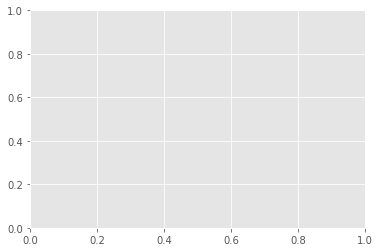

In [9]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["classification_output_loss"], label="train_c_loss")
plt.plot(N, hist.history["segmentation_output_loss"], label="train_s_loss")

plt.plot(N, hist.history["classification_output_acc"], label="train_c_acc")
plt.plot(N, hist.history["segmentation_output_acc"], label="train_s_acc")
plt.plot(N, hist.history["seg-out_dice_coef"], label="train_s_dice")

# plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.plot(N, hist.history["val_classification_output_loss"], label="val_c_loss")
plt.plot(N, hist.history["val_segmentation_output_loss"], label="val_s_loss")

plt.plot(N, hist.history["val_classification_output_acc"], label="val_c_acc")
plt.plot(N, hist.history["val_segmentation_output_acc"], label="val_s_acc")
plt.plot(N, hist.history["val_seg-out_dice_coef"], label="val_s_dice")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/DSC")
plt.legend()
plt.savefig(os.path.join('output/', Name+'.png'))


In [10]:
print("------Start predicting------")



predictions_c, predictions_s, predictions_s2 = model.predict(test_x, batch_size=32)


print("------------------------------------------------ Classification testing ------------------------------------------------")

print(classification_report(test_c_y.argmax(axis=1), predictions_c.argmax(axis=1), target_names=lb.classes_, digits=6))

print("------------------------------------------------ Segmentation testing ------------------------------------------------")


# evaluate the model
# loss = model.evaluate(test_x, [test_c_y, test_s_y], verbose=0)
loss, cla_loss, seg_loss, seg_loss2, cla_acc, seg_acc, seg_dice_coef = model.evaluate(test_x, [test_c_y, test_s_y, test_s_y], verbose=0)
print('Test total loss:', loss)
print('Test classification loss:', cla_loss)
print('Test segmentation loss:', seg_loss)

print('Test classification accuracy:', cla_acc)
print('Test segmentation accuracy:', seg_acc)
print('Test segmentation dice_coef:', seg_dice_coef)

preds_c, preds_s, preds_s2 = model.predict(test_x, batch_size=8, verbose=1)
test_mask = test_s_y.flatten()
pred_mask = preds_s.flatten()
fpr, tpr, thresholds = roc_curve(test_mask, pred_mask, pos_label=1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# Precision, Recall, accuracy, F1, IoU = p_r_f1_iou(test_s_y, preds_s)
# print('Precision:', Precision)
# print('Recall:', Recall)
# print('m_Iou:', IoU)
# print('F1_score:', F1)



------Start predicting------
------------------------------------------------ Classification testing ------------------------------------------------
                  precision    recall  f1-score   support

   bengin_images   0.895833  1.000000  0.945055        43
malignant_images   1.000000  0.761905  0.864865        21

        accuracy                       0.921875        64
       macro avg   0.947917  0.880952  0.904960        64
    weighted avg   0.930013  0.921875  0.918743        64

------------------------------------------------ Segmentation testing ------------------------------------------------
Test total loss: 0.21510875597596169
Test classification loss: 0.43203072249889374
Test segmentation loss: 0.19934973865747452
Test classification accuracy: 0.921875
Test segmentation accuracy: 0.9558002650737762
Test segmentation dice_coef: 0.9550652801990509
64/64 [==============================] - 0s 8ms/step
AUC: 0.9860011957940111


# 生成肿块分割预测结果

In [ ]:
def mask2gray(mask, input_type=None):
    if input_type is 'pred':
        mask0 = mask[:, :, 0]
        mask1 = mask[:, :, 1]
        mask = mask1 - mask0
        print("mask.shape: ", mask.shape)
        #mask = np.argmax(mask, axis=-1)
        # print( mask[mask > 0.5] )
        mask[mask > 0] = 255
        mask[mask <= 0] = 0
    mask = mask.astype(dtype=np.uint8)
    rst = mask.copy()
    cv.normalize(mask, rst, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    return rst

print("------------------------------ Saving predictions ------------------------------------")

import glob
img_size = target
preds_savePath = os.path.join("./seg_prediction/BUSI/", Name)
class_path_list = glob.glob(testX_dir+'*\\*')
test_img_Names = []
for class_path in class_path_list:
    all_images_list = glob.glob(class_path + '*\\*')
    print(all_images_list)
    for image_path in all_images_list:
        print(image_path)
#         images_name = image_path.split()

# for i in range(test_x.shape[0]):
#     img = test_orignal_images[i]

#     gt = test_Y[i, :, :, 1]
#     gt = mask2gray(gt)

#     pred = preds[i]
#     prediction = mask2gray(pred, input_type='pred')

#     save_img = np.zeros([img_size[0], img_size[1]*3, 3], dtype=np.uint8)
#     save_img[:, 0:img_size[0], :] = img[:, :, ::-1]
#     save_img[:, img_size[0]:img_size[1] * 2, :] = cv.cvtColor(gt, cv.COLOR_GRAY2RGB)
#     save_img[:, img_size[0] * 2:img_size[1] * 3, :] = cv.cvtColor(prediction, cv.COLOR_GRAY2RGB)

#     savePath = os.path.join(preds_savePath, "joint")

#     if not os.path.exists(savePath):
#         os.makedirs(savePath)

#     cv.imwrite(savePath + "{0}".format(test_img_Names[i]), save_img)

# for i in range(test_x.shape[0]):

#     img = test_orignal_images[i]

#     gt = test_Y[i, :, :, 1]
#     gt = mask2gray(gt)
#     gt = cv.cvtColor(gt, cv.COLOR_GRAY2RGB)

#     pred_mask = preds[i]
#     pred_mask = mask2gray(pred_mask, input_type='pred_mask')

#     savePath = os.path.join(preds_savePath, "Imgs/")
#     saveMaskPath = os.path.join(preds_savePath, "Mask/")
#     savePredPath = os.path.join(preds_savePath, "Pred/")

#     if not os.path.exists(savePath):
#         os.makedirs(savePath)
#     if not os.path.exists(saveMaskPath):
#         os.makedirs(saveMaskPath)
#     if not os.path.exists(savePredPath):
#         os.makedirs(savePredPath)

#     cv.imwrite(os.path.join(savePath, "{0}".format(test_img_Names[i])), img)
#     cv.imwrite(os.path.join(saveMaskPath, "{0}".format(test_img_Names[i])), gt)
#     cv.imwrite(os.path.join(savePredPath, "{0}".format(test_img_Names[i])), pred)

